# Redrock on BOSS data

This tutorial demonstrates running redrock on BOSS data.
Some pieces are a bit cryptic because of code organized for parallelism
rather than interactive use.  In general one would use the `rrboss` script,
but this tutorial pokes under the hood a bit to see the pieces.

In [1]:
%pylab inline
import os
import numpy as np
from redrock.external import boss
from redrock.zfind import zfind

from redrock.targets import Spectrum, Target, DistTargetsCopy
from redrock.templates import load_dist_templates

Populating the interactive namespace from numpy and matplotlib


Read a subset of the data from spPlate-3678-55208.fits.
* If fiberid is not specified, all fibers from the plate are read.
* If use_frames is True, the individual exposures will be discovered from the spPlate header. The corresponding spCFrame files should be in the same directory as the spPlate file.
* BEWARE: The targets list might not have the same order as the input fiberid

**NOTE**: BOSS/eBOSS is publicly accessible and can be downloaded
from https://data.sdss.org/sas/dr14/eboss/spectro/redux/

They are also available at NERSC: /project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0

In [2]:
if 'NERSC_HOST' in os.environ:
    spplate = "/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/3678/spPlate-3678-55208.fits"
else:
    spplate="data/spPlate-3678-55208.fits"
targets,meta = boss.read_spectra(spplate, use_frames=False, fiberid=[36,51,52,54,60])

DEBUG: read /project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/3678/spPlate-3678-55208.fits 


In [3]:
dtargets = DistTargetsCopy(targets)
dwave = dtargets.wavegrids()
dtemplates = load_dist_templates(dwave)
templates = dict()
for dt in dtemplates:
    templates[dt.template.full_type] = dt.template

DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-3.9968 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Ldwarf.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
Read and broadcast of 11 templates: 0.1 seconds
Rebinning templates: 15.6 seconds


# Doing the redshifts scans

Define the templates and to the redshift scans over those templates.

This might take a few minutes, please be patient! Your computer is working hard.

In [4]:
zscan, zfit = zfind(dtargets, dtemplates)

Computing redshifts
  Scanning redshifts for template GALAXY
    Progress:   0 %
    Progress:  10 %
    Progress:  20 %
    Progress:  30 %
    Progress:  40 %
    Progress:  50 %
    Finished in: 6.4 seconds
  Scanning redshifts for template QSO
    Progress:   0 %
    Progress:  10 %
    Progress:  20 %
    Progress:  30 %
    Progress:  40 %
    Progress:  50 %
    Finished in: 3.0 seconds
  Scanning redshifts for template STAR:::A
    Progress:   0 %
    Progress:  10 %
    Progress:  20 %
    Progress:  30 %
    Progress:  40 %
    Progress:  50 %
    Finished in: 0.3 seconds
  Scanning redshifts for template STAR:::B
    Progress:   0 %
    Progress:  10 %
    Progress:  20 %
    Progress:  30 %
    Progress:  40 %
    Progress:  50 %
    Finished in: 0.3 seconds
  Scanning redshifts for template STAR:::CARBON
    Progress:   0 %
    Progress:  10 %
    Progress:  20 %
    Progress:  30 %
    Progress:  40 %
    Progress:  50 %
    Finished in: 0.1 seconds
  Scanning redshifts f

# Exploring the output

The zscan dictionary contains the all the redshift scan information for each target and each template.

For example, here's a plot of the $\chi^2$ vs $z$ for the first target.


Text(0,0.5,'$\\chi^2$')

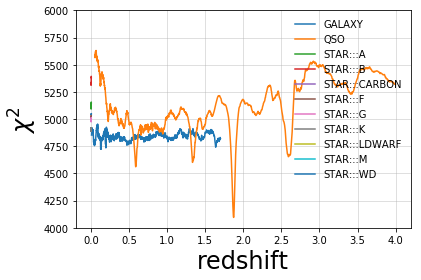

In [5]:
targetid = targets[0].id
for template in dtemplates:
    full_type = template.template.full_type
    plot(zscan[targetid][full_type]['redshifts'],\
         zscan[targetid][full_type]['zchi2'],label=full_type)

legend(loc=0,frameon=False)
ylim(4000,6000)
grid()
xlabel("redshift",fontsize=24)
ylabel("$\chi^2$",fontsize=24)

Excellent! We find that the best fit is corresponds to a QSO template at redshift around 1.8. 

Let's confirm that by looking at the zfit table:

In [6]:
print("Redrock thinks {} is a {} at redshift {}".format(targets[0].id,zfit[0]['spectype'],zfit[0]['z']))

Redrock thinks 3678552080036 is a QSO at redshift 1.870964990456901


Let's now make a plot of the spectrum and its best fit. The best fit is obtained by evaluating the best fit template (in this case a QSO) at the best fit redshift. Let's list the template types:

In [11]:
for i,t in enumerate(templates.values()):
    print(i,t.full_type)

0 GALAXY
1 QSO
2 STAR:::A
3 STAR:::B
4 STAR:::CARBON
5 STAR:::F
6 STAR:::G
7 STAR:::K
8 STAR:::LDWARF
9 STAR:::M
10 STAR:::WD


We now evaluate the template 'QSO' at the best fit redshift:

In [12]:
tid = targets[0].id
t_qso = templates['QSO']

## several minima are stored in the zfit table
minumum_number = 0

## select the target id and minumum number
w = (zfit[:]['targetid']==tid) & (zfit[:]['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z'][0]

## compute the best fit:
fit = t_qso.eval(coeff[:4],targets[0].spectra[0].wave,zbest)

## remultiply by (1+z)
fit *= (1+zbest)

(-1, 6)

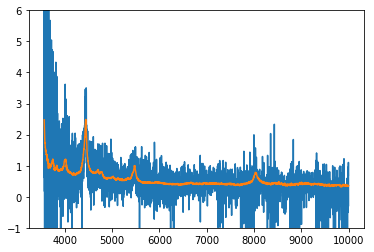

In [13]:
wave=targets[0].spectra[0].wave
flux = targets[0].spectra[0].flux
plot(wave,flux)
plot(wave,fit)
ylim(-1,6)

Let's add a bit of rebinning to smooth out the noise:

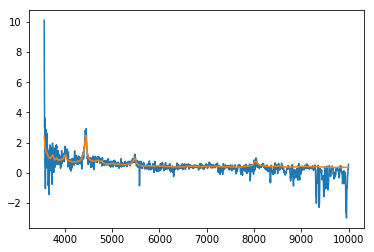

In [14]:
i = np.arange(len(fit),dtype=float)
A = i - i[:,None]
rebin = 5
w = abs(A)<rebin
A[w]=1.
A[~w]=0
A /= A.sum(axis=1).reshape(-1,1)
plot(wave,A.dot(flux))
plot(wave,A.dot(fit))